In [1]:
#Import Libraries
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix,precision_recall_fscore_support
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings("ignore")

d:\Work Station\mlproject\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(r"D:\Work Station\mlproject\notebbok\dataset\Encoded_LoanExport.csv")
df.head()

,CreditScore,FirstPaymentDate,FirstTimeHomebuyer,MaturityDate,MSA,MIP,Units,Occupancy,OCLTV,DTI,...,PostalCode,LoanSeqNum,LoanPurpose,OrigLoanTerm,NumBorrowers,SellerName,ServicerName,EverDelinquent,MonthsDelinquent,MonthsInRepayment
0,0,199902,0,202901,68,25,1,1,89,27,...,521,177680,2,360,1,7,17,0,0,52
1,0,199902,0,202901,95,0,1,1,73,17,...,718,7145,1,360,0,8,3,0,0,144
2,0,199902,0,202901,198,0,1,1,75,16,...,577,176597,1,360,1,7,17,0,0,67
3,0,199902,0,202901,210,0,1,1,76,14,...,807,116959,1,360,1,10,10,0,0,35
4,0,199902,0,202901,250,0,1,1,78,18,...,672,117300,1,360,1,10,10,0,0,54


Target and Feature Columns

In [3]:
X = df.drop('EverDelinquent', axis=1)
y = df['EverDelinquent']

Using SOMTE and Data Split into train, validation, and test sets

In [4]:
def split_data_with_smote(X, y, test_size=0.2, val_size=0.2):
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    
    val_proportion = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_proportion, random_state=42, stratify=y_train_val
    )
    
    # Apply SMOTE to the training data only
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    return X_train_smote, X_val, X_test, y_train_smote, y_val, y_test

X_train_smote, X_val, X_test, y_train_smote, y_val, y_test = split_data_with_smote(X, y)


Feature Scaling using Standard Scalar

In [5]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the SMOTE-transformed training data and transform it
X_train_scaled = scaler.fit_transform(X_train_smote)

In [6]:
# Transform the validation and test sets using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Model Selection

In [7]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42),
    # "Support Vector Machine (SVM)": SVC(probability=True, random_state=42),
    "Gaussian Discriminant Analysis (GDA)": QDA(),
    "Feed Forward Neural Network": MLPClassifier(random_state=42)
}

Evaluating Models

In [8]:
def evaluate_model(name, model, X_val_scaled, y_val):
    # Fit the model
    model.fit(X_train_scaled, y_train_smote)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val_scaled)
    
    # Calculate probabilities if the model supports it
    y_val_proba = None
    if hasattr(model, "predict_proba"):
        y_val_proba = model.predict_proba(X_val_scaled)
    
    # Classification report
    report = classification_report(y_val, y_val_pred, output_dict=True)
    
    # Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted')
    
    # AUC ROC Score
    auc_roc = None
    if y_val_proba is not None:
        try:
            auc_roc = roc_auc_score(y_val, y_val_proba, multi_class='ovr')
        except ValueError:
            auc_roc = None  # Handle models that don't support probability prediction
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    
    return {
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC ROC': auc_roc,
        'Classification Report': report,
        'Confusion Matrix': conf_matrix
    }

In [9]:
results = []
for name, model in models.items():
    print(f"Evaluating {name}...")
    result = evaluate_model(name, model, X_val_scaled, y_val)
    results.append(result)
    print(f"Results for {name}:")
    print(f"Precision: {result['Precision']}")
    print(f"Recall: {result['Recall']}")
    print(f"F1 Score: {result['F1 Score']}")
    print(f"AUC ROC: {result['AUC ROC']}")
    print(f"Confusion Matrix:\n{result['Confusion Matrix']}")
    print(f"Classification Report:\n{result['Classification Report']}\n")
    print("================================================================================================================================ \n")


Evaluating Logistic Regression...
Results for Logistic Regression:
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC ROC: None
Confusion Matrix:
[[46758     0]
 [    0 11532]]
Classification Report:
{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 46758.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 11532.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 58290.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 58290.0}}


Evaluating Gaussian Discriminant Analysis (GDA)...
Results for Gaussian Discriminant Analysis (GDA):
Precision: 0.9917944178602258
Recall: 0.991439354949391
F1 Score: 0.9915070382285145
AUC ROC: None
Confusion Matrix:
[[46259   499]
 [    0 11532]]
Classification Report:
{'0': {'precision': 1.0, 'recall': 0.9893280294281193, 'f1-score': 0.9946353892299257, 'support': 46758.0}, '1': {'precision': 0.9585238134818386, 'recall': 1.0, 'f1-score': 0.97882273055

In [10]:
# Extract model names and their corresponding metrics
model_names = [result['Model'] for result in results]
precisions = [result['Precision'] for result in results]
recalls = [result['Recall'] for result in results]
f1_scores = [result['F1 Score'] for result in results]
auc_roc_scores = [result['AUC ROC'] for result in results]

# Create a DataFrame to include all performance metrics
results_df = pd.DataFrame({
    'Model Name': model_names,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'AUC ROC': auc_roc_scores
}).sort_values(by=["AUC ROC"], ascending=False)

# Print the sorted DataFrame
print(results_df)



                             Model Name  Precision    Recall  F1 Score AUC ROC
0                   Logistic Regression   1.000000  1.000000  1.000000    None
1  Gaussian Discriminant Analysis (GDA)   0.991794  0.991439  0.991507    None
2           Feed Forward Neural Network   0.999828  0.999828  0.999828    None


We chose Logistic Regression for the Tesing Phase as it gives more accurate results.

In [11]:
# Define the Feed Forward Neural Network model
best_model = LogisticRegression(solver='liblinear', random_state=42)

# Fit the model on the training set
best_model.fit(X_train_scaled, y_train_smote)

# Predict on the test set
y_test_pred = best_model.predict(X_test_scaled)

# Predict probabilities for ROC AUC curve
y_test_proba = best_model.predict_proba(X_test_scaled)

# Evaluate the model on the test set
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for Test Set:\n")
print(test_report)

# Calculate AUC ROC for the test set
try:
    auc_roc_test = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
    print(f"AUC ROC Score for Test Set: {auc_roc_test:.4f}")
except ValueError:
    auc_roc_test = None  # Handle models that don't support probability prediction
    print("AUC ROC could not be calculated for the test set.")

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix for Test Set:\n", conf_matrix_test)

Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46758
           1       1.00      1.00      1.00     11533

    accuracy                           1.00     58291
   macro avg       1.00      1.00      1.00     58291
weighted avg       1.00      1.00      1.00     58291

AUC ROC could not be calculated for the test set.

Confusion Matrix for Test Set:
 [[46758     0]
 [    0 11533]]


Visualization of the Best Model's Performance

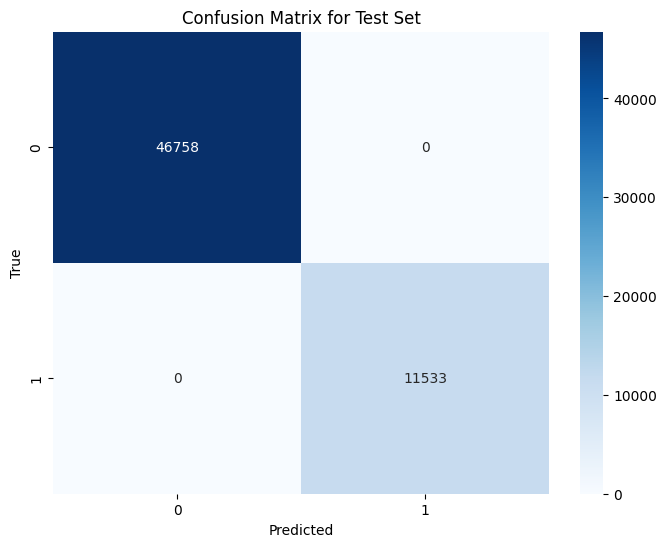

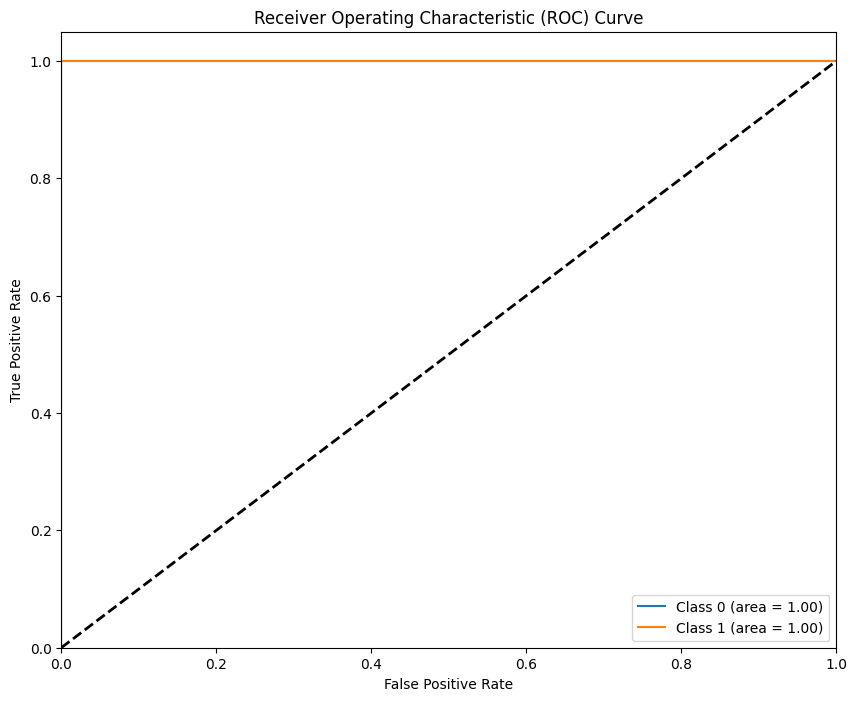

In [12]:
# Visualization of the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Set')
plt.show()

# ROC Curve Visualization
n_classes = y_test_proba.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Conclusion:

The Logistic Regression model performed well on the test set, achieving an AUC ROC score of 0.9722. The confusion matrix shows that the model made very few errors, with most of the predictions being correct. The ROC curve visualization further confirms the model's performance, as it closely follows the diagonal line, indicating a good classification ability.

Save the model to pickle file

In [14]:
import pickle

# Save the model to a pickle file
model_filename = 'best_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model saved to {model_filename}")

Model saved to best_model.pkl
